In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import atomic.features as fs
import matplotlib.pyplot as plt
import pattern.vis as vis
import sklearn.mixture as mix
import matplotsoccer as mps
import atomic.vaep as vaep

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")
predictions_h5 = os.path.join(datafolder,"atomic-predictions-one-action.h5")

In [4]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [5]:
with pd.HDFStore(spadl_h5) as spadlstore,\
    pd.HDFStore(predictions_h5) as predstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        p = predstore[f"game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        a["is_home"] = a.team_id == game.home_team_id
        assert len(a) == len(p)
        a = pd.concat([a,p],axis=1)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]
actions = pd.concat([actions,vaep.value(actions,actions.scores,actions.concedes)],axis=1)

380it [00:12, 29.70it/s]


In [7]:
# Make a nice action subset
import pattern.action as pat

a = actions[200000:300000].fillna(0)
#a = actions.fillna(0)
a = pat.simplify(a)
#a["type_name"] = a.type_name.mask(~a.is_home,a.type_name + "_opp")
#a["x"] = a.x.mask(a.type_name=="goal",105)
#a["y"] = a.y.mask(a.type_name=="goal",32.5)
#a["dx"] = a.dx.mask(a.type_name=="shot",105-a.x)
#a["dy"] = a.dy.mask(a.type_name=="shot",32.5-a.y)
a = pd.concat([a,fs.polar(a),fs.movement_polar(a),fs.direction(a)],axis=1)
a

,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,...,type_name,offensive_value,defensive_value,vaep_value,dist_to_goal_a0,angle_to_goal_a0,mov_d_a0,mov_angle_a0,dx_a0,dy_a0
200000,14452.0,1.0,288,592.00,00:09:52.995,32.0,3257.0,73.235294,11.189873,-8.823529,...,pass,-0.002549,-0.000123,-0.002672,39.106245,0.622768,8.865415,0.097245,-0.995275,-0.097092
200001,14452.0,1.0,289,593.00,00:09:54.734,25.0,3272.0,40.588235,57.670886,-0.000000,...,interception,0.000408,0.001379,0.001788,68.623511,0.352173,0.000000,0.000000,-0.000000,-0.000000
200002,14452.0,1.0,290,594.00,00:09:54.734,25.0,3272.0,40.588235,57.670886,0.882353,...,pass,0.000125,0.000104,0.000228,68.623511,0.352173,1.232661,0.773011,0.715811,0.698294
200003,14452.0,1.0,291,594.50,00:09:55.873,32.0,3257.0,63.529412,9.468354,0.000000,...,interception,0.001691,0.000545,0.002236,48.183102,0.534178,0.000000,0.000000,0.000000,0.000000
200004,14452.0,1.0,292,594.75,00:09:55.873,32.0,3257.0,63.529412,9.468354,7.941176,...,dribble,0.003478,0.000085,0.003564,48.183102,0.534178,8.125633,0.213481,0.977299,0.211863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,14366.0,2.0,1882,311.00,00:05:11.371,32.0,3331.0,50.294118,50.784810,28.235294,...,pass,-0.002757,0.000006,-0.002750,57.222927,0.297701,44.527327,-0.883937,0.634112,-0.773242
299996,14366.0,2.0,1883,312.00,00:05:13.331,23.0,7169.0,26.470588,51.645570,0.000000,...,interception,0.000659,0.003289,0.003948,80.487481,0.221029,0.000000,0.000000,0.000000,0.000000
299997,14366.0,2.0,1884,313.00,00:05:13.331,23.0,7169.0,26.470588,51.645570,12.352941,...,pass,0.000234,0.000055,0.000289,80.487481,0.221029,14.142602,0.508541,0.873456,0.486903
299998,14366.0,2.0,1885,314.00,00:05:15.345,23.0,3579.0,38.823529,58.531646,0.000000,...,receival,0.000333,0.000924,0.001258,70.577099,0.354996,0.000000,0.000000,0.000000,0.000000


In [32]:
import sklearn.mixture as mix



#gmm = mix.GaussianMixture(20)
#gmm.fit(df[cols])


In [41]:
from sklearn.mixture._gaussian_mixture import (
    _estimate_gaussian_parameters,
    _compute_precision_cholesky,
    )

import sklearn.cluster as cluster

class WeightedGMM(mix.GaussianMixture):
    
    def fit(self,df,weights=None,*k,**kw):
        if weights is None:
            weights = np.array([1] * len(df))
        pos_weight_idx = weights > 1e-10
        self.sample_weights = weights[pos_weight_idx]
        super().fit(df[pos_weight_idx],*k,**kw)
        
    def _m_step(self, X, log_resp):
            """M step.
            Parameters
            ----------
            X : array-like, shape (n_samples, n_features)
            log_resp : array-like, shape (n_samples, n_components)
                Logarithm of the posterior probabilities (or responsibilities) of
                the point of each sample in X.
            """
            n_samples, _ = X.shape
            a = self.sample_weights
            b = np.exp(log_resp)
            resp = (a*b.T).T
            self.weights_, self.means_, self.covariances_ = (
                _estimate_gaussian_parameters(X,resp, self.reg_covar,
                                              self.covariance_type))
            self.weights_ /= n_samples
            self.precisions_cholesky_ = _compute_precision_cholesky(
                self.covariances_, self.covariance_type)
            
    def _initialize_parameters(self, X, random_state):
            """Initialize the model parameters.
            Parameters
            ----------
            X : array-like, shape  (n_samples, n_features)
            random_state : RandomState
                A random number generator instance.
            """
            n_samples, _ = X.shape

            if self.init_params == 'kmeans':
                resp = np.zeros((n_samples, self.n_components))
                clus = cluster.KMeans(n_clusters=self.n_components, n_init=1,
                                       random_state=random_state)
                label = clus.fit(X,sample_weight=self.sample_weights).labels_
                resp[np.arange(n_samples), label] = 1
            elif self.init_params == 'random':
                resp = random_state.rand(n_samples, self.n_components)
                resp /= resp.sum(axis=1)[:, np.newaxis]
            else:
                raise ValueError("Unimplemented initialization method '%s'"
                                 % self.init_params)

            self._initialize(X, resp)

Initialization 0
Initialization converged: True


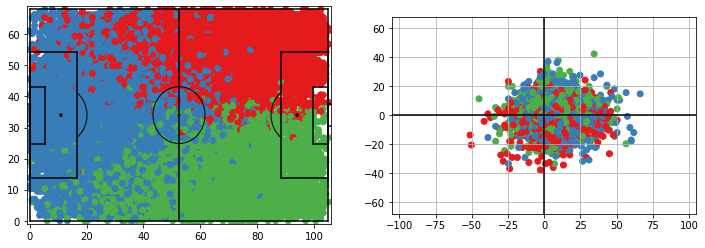

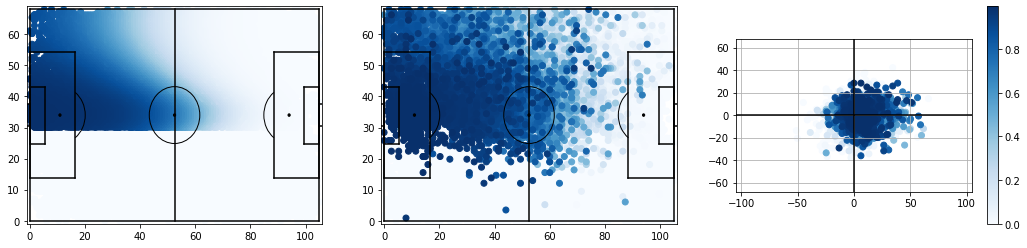

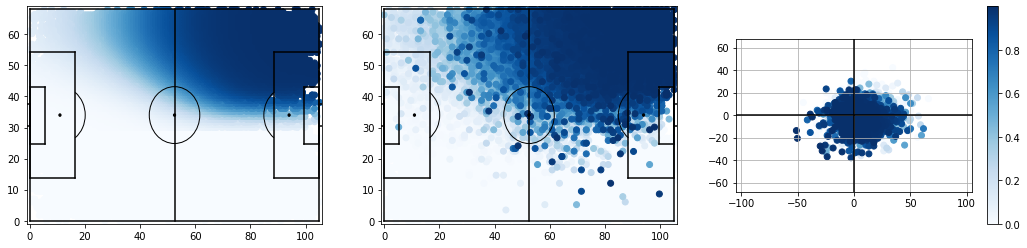

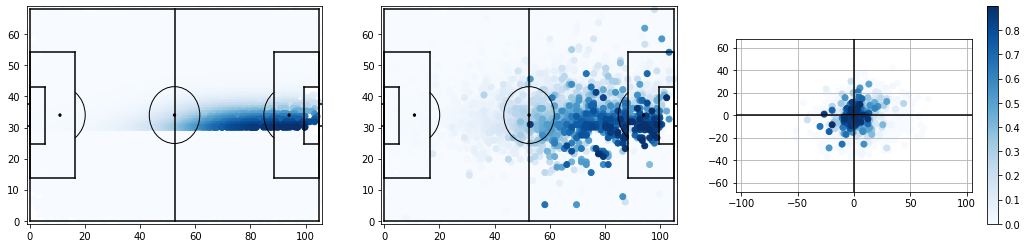

In [42]:
import pattern.vis as vis
import matplotlib.pyplot as plt

cols = ["x","y",
        #"dx","dy"
        #"dist_to_goal_a0",
        #"angle_to_goal_a0",
        #"mov_d_a0",
        #"mov_angle_a0"
        #"dx_a0",
        #"dy_a0"
       ]

df = a[a.type_name == "dribble"]

nu = WeightedGMM(3,init_params="kmeans",verbose=1,n_init=1,max_iter=200)
#nu = mix.GaussianMixture(4,init_params="kmeans",verbose=0,n_init=5,max_iter=200)

weights = (df.y > 30).apply(float).values
#nu.fit(df[cols],weights)
nu.fit(df[cols])

vis.plot_gmm_actions(nu,df,cols,samplefn="uni")
#vis.plot_gmm_actions(nu,df,cols,samplefn="max")

labelprobs = (weights*nu.predict_proba(df[cols]).T).T
for i in range(len(labelprobs[0])):
    axs = vis.axes3()
    dfc = df.copy()
    dfc["membership"] = labelprobs[:,i]
    dfc = dfc.sort_values("membership",ascending=True)
    sc = axs[0].scatter(dfc.x,dfc.y,c=dfc.membership,cmap="Blues")
    plt.colorbar(sc)
    axs[1].scatter(dfc.x + dfc.dx,dfc.y + dfc.dy,c=dfc.membership,cmap="Blues")
    axs[2].scatter(dfc.dx,dfc.dy,c=dfc.membership,cmap="Blues")
    plt.show()

In [ ]:
#ac = a[a.type_name.isin(["cross","corner","throw_in","shot"])]
candidates = pat.candidates(a,["x","y","dx","dy","logvalue"],25,True)
lns = {t : len(a[a.type_name==t]) for t in set(a.type_name)}

In [ ]:
list((m.n_components,s) for t,m,s in candidates if t == "shot")

In [ ]:
#list((m.n_components,s) for t,m,s in normcandidates if t=="shot")
ov = a.groupby("type_name")[["concedes","scores"]].sum()
ov["combined"] = abs(ov.scores-ov.concedes)
ov = dict(ov.combined)
ov

In [ ]:
import cvxpy as cp

n = 150

normcandidates = [(t,m,
                   s#*ov[t]#/lns[t]*np.log(lns[t])#tnp.log(lns[t])
                  ) for t,m,s in candidates6]# if t not in ["goal","shot_penalty"]]

# normcandidates = [(t,m,
#                    -covarnorm(m)#*(lns[t])
#                   ) for t,m,s in candidates]

selected_candidates = pat.ilp_select_candidates(normcandidates,n,verbose=False)

gmme = pat.GMMEnsemble(["x","y",
                               "dx","dy",
                               "scores",
                                "concedes"]
                       ,{k:m for k,m,s in selected_candidates})
gmme.components()

In [ ]:
np.argsort([3,2])

In [ ]:
import pattern.vis as vis
for k, gmm in sorted(list(gmme.models.items())):
    df = a[a.type_name == k]
    print(k,gmm.n_components,len(df))
    #vis.plot_gmm(gmm)
    vis.plot_gmm_actions(gmm,df,gmme.cols,samplefn="uni")
    vis.plot_components_arrows(gmm,cols=3)

In [ ]:
probas = gmme.predict_proba(a)

In [ ]:
for ty in gmme.models:
    for k in range(gmme.models[ty].n_components):
        col = ty + str(k+1)
        print(col)
        v = probas[col].values
        
        fig,axs = plt.subplots(1,2)
        fig.set_size_inches(3*6,6)
        axs[0].hist(v[v>0.01])
        mps.field(ax=axs[1],show=False)
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=axs[1])
        plt.show()

In [ ]:
ucprobas = pat.uncouple_probabilities(probas,a.is_home.values)
ucprobas
ucprobas.values.sum()

In [ ]:
prev = ucprobas.values[:-1]
nex = ucprobas.values[1:]
print(prev.shape)
trans = np.dot(prev.T,nex)
plt.matshow(trans)
plt.colorbar()
plt.show()
trans /= trans.sum()
# for i in range(len(trans[0])):
#     trans[i,:] /= trans[i,:].sum()
trans.sum()
ori_trans = trans

In [ ]:
forwardtrans = trans.copy()
for i in range(len(forwardtrans[0])):
     forwardtrans[i,:] /= forwardtrans[i,:].sum()
forwardtrans.sum()

backwardtrans = trans.T.copy()
for i in range(len(backwardtrans[0])):
     backwardtrans[i,:] /= backwardtrans[i,:].sum()
backwardtrans.sum()

In [ ]:
def get_name(i):
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    return "_".join([ty,str(k),str(is_opp)])

In [ ]:
from sklearn.cluster import SpectralClustering

nc = 10

clustering = SpectralClustering(affinity="precomputed",n_clusters=nc).fit((sim + sim.T)/2)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clustering.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

In [ ]:
sim = (np.dot(forwardtrans,backwardtrans) + np.dot(backwardtrans,forwardtrans))/2

from sklearn.cluster import KMeans

nc = 30

clus = KMeans(nc).fit(sim)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clus.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

In [ ]:
from collections import Counter

sim = (np.dot(forwardtrans,backwardtrans) + np.dot(backwardtrans,forwardtrans))/2

plt.matshow(sim)
plt.colorbar()
plt.show()

from sklearn.cluster import AgglomerativeClustering
nc = 50
clustering = AgglomerativeClustering(affinity="euclidean",linkage="average",n_clusters=nc).fit(sim.T)

for label in range(nc):
    print(label)
    ax = mps.field(show=False)
    prototypes = []
    for i in np.where(clustering.labels_ == label)[0]:
        ty,k = gmme._global_to_local(i % gmme.total_components())
        is_opp = i > gmme.total_components() - 1
        prototypes.append((ty,is_opp))
        if is_opp:
            color = "red"
        else:
            color = "blue"
        vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color=color,mirror=is_opp,show=False)
    print(Counter(prototypes))
    plt.show()

In [ ]:
i = 170
ty,k = gmme._global_to_local(i % gmme.total_components())
is_opp = i > gmme.total_components() - 1
print(ty,k,is_opp)
vis.plot_component_w_arrow(gmme.models[ty],k,color="red",mirror=is_opp)

oldty,oldk,oldopp = ty,k,is_opp

v = np.zeros(gmme.total_components()*2)
v[i] = 1

forv = np.dot(np.dot(v,forwardtrans),backwardtrans)
plt.plot(forv)
plt.show()

backv = np.dot(np.dot(v,backwardtrans),forwardtrans)
plt.plot(backv)
plt.show()

newv = (forv + backv)/2
plt.plot(newv)
plt.show()

for j in np.argsort(newv)[::-1][:4]:
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    print(ty,k,is_opp)
    ax = vis.plot_component_w_arrow(gmme.models[oldty],oldk,color="red",mirror=oldopp,show=False)
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp)

In [ ]:
trans1 = ori_trans.copy()
for _i in range(10):
    print(trans1.sum())
    trans1 = np.dot(ori_trans.T,trans1)
    trans1 /= trans1.sum()

In [ ]:
delta_trans = trans1 - ori_trans
plt.matshow(delta_trans)
plt.colorbar()
plt.show
delta_trans.max(), delta_trans.min()

In [ ]:
trans = delta_trans
trans = trans1

In [ ]:
trans.sum()

In [ ]:
plt.hist([p for p,i,j in probs])
plt.show()

In [ ]:
probs = []
for i in range(len(trans)):
    for j in range(len(trans)):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs]# if i != j]

cols = list(ucprobas.columns)

def test(i,j):
    return True
    return "goal1" in cols[j]# and "opp" not in cols[j]
    return "shot" in cols[i] and "opp" not in cols[j]

interestmovs = [(p,i,j) for p,i,j in movs 
                if test(i,j)
                #"pass" not in cols[i]
                   # and "receival" not in cols[i]
                   # and "dribble" not in cols[i]
               ]

for p,i,j in interestmovs[:10]:
    print(p,i,j)
    print(cols[i],"(red)","->",cols[j],"(blue)")
    ax = mps.field(show=False)
    ty,k = gmme._global_to_local(i % gmme.total_components())
    is_opp = i > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="red",mirror=is_opp,show=False)
    ty,k = gmme._global_to_local(j % gmme.total_components())
    is_opp = j > gmme.total_components() - 1
    vis.plot_component_w_arrow(gmme.models[ty],k,ax=ax,color="blue",mirror=is_opp,show=False)
    plt.show()

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 50:
        break

In [ ]:
labels = np.argmax(probas.values,axis=1)

for p,i,j in movs[:10000]:
    cols = gmme._columns()
    if "shot" in cols[j] and "kick" not in cols[j]:# or True:
        print(p,i,j)
        print(cols[i],"(blue)","->",cols[j],"(red)")
        l_idx = (labels == i) | (labels == j)
        twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
        axs = vis.locmovaxes()
        axs[0].scatter(a.x[l_idx],a.y[l_idx],color=twocolors)
        axs[1].scatter(a.dx[l_idx],a.dy[l_idx],color=twocolors)
        plt.show()
    if p < 5:
        break